In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import scipy
import sklearn
import copy
import importlib


In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc, precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score, cross_validate, KFold
from sklearn.metrics import make_scorer, matthews_corrcoef


In [3]:
import scanpy as sc
# import scvelo as scv

# read the full GSE dataset
data = sc.read_h5ad('/Users/evanli/Documents/Research_datasets/PBMC_Hao/GSE164378_Hao/Hao_PBMC_GSE164378.h5ad')
data.shape

(161764, 33538)

In [5]:
### Raw counts were not normalizaed
# CPM
sc.pp.normalize_total(data, target_sum=1e6)

# log1p
sc.pp.log1p(data)

In [6]:
data.obs['celltype.l1'] = data.obs['celltype.l1'].str.replace(' ', '_')

label = data.obs['celltype.l1'].tolist()
types = np.unique(label).tolist()
# types = [s.replace(' ', '_') for s in types]
print(types)

['B', 'CD4_T', 'CD8_T', 'DC', 'Mono', 'NK', 'other', 'other_T']


## Read features

In [7]:
# Level 1 ADlasso features by loss difference convergence
import os
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/feature_selection')

features_dict = {}
# Read features for each celltype
for celltype in types:
    try:
        feature_df = pd.read_csv(f'{celltype}_features.txt', names=['Gene', 'Weight', 'Tendency'], sep='\t')
        features_dict[celltype] = feature_df
    except:
        print('skipping:', celltype)
        continue
    # print(celltype, 'Feature count:', feature_df.shape[0])
    # print(celltype, 'Positive feature count:', feature_df[feature_df['Tendency'] == 1].shape[0])
    # print('------------------')

In [8]:
count_df = pd.DataFrame(columns=['Feature_count', 'Positive_feature_count'])
for celltype in features_dict.keys():
    feature_df = features_dict[celltype]
    feature_count = feature_df.shape[0]
    positive_count = feature_df[feature_df['Tendency'] == 1].shape[0]
    count_df.loc[celltype] = [feature_count, positive_count]
count_df

,Feature_count,Positive_feature_count
B,13,7
CD4_T,200,83
CD8_T,25,6
DC,25,15
Mono,21,11
NK,28,14
other,42,27
other_T,61,26


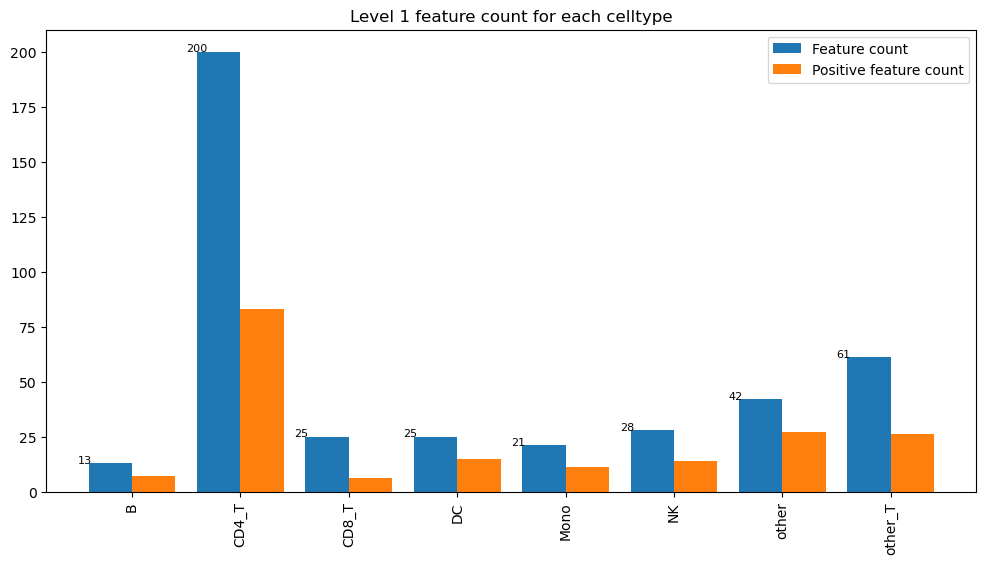

In [9]:
# plot barplot
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(count_df.index))
bar_width = 0.4

ax.bar(x - bar_width/2, count_df['Feature_count'], bar_width, label='Feature count')
ax.bar(x + bar_width/2, count_df['Positive_feature_count'], bar_width, label='Positive feature count')

# Add the values to each bar
for i, v in enumerate(count_df['Feature_count']):
    plt.text(i-0.5, v, str(v), fontsize=8)
# for i, v in enumerate(count_df['Positive_feature_count']):
#     plt.text(i, v, str(v), fontsize=8)

ax.set_xticks(x)
ax.set_xticklabels(count_df.index)
plt.xticks(rotation=90)
plt.title('Level 1 feature count for each celltype')
ax.legend()
# plt.savefig('L2_feature_count.png', dpi=300, bbox_inches='tight')
plt.show()

## Build classifiers (K-fold CV)

In [34]:
import pickle

def LR_kfold(data, all_features_dict, celltype, k=5):
    # subset data to celltype features
    X = data[:, all_features_dict[celltype]['Gene'].tolist()].X
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # Kfold cross validation
    scoring = {
        'accuracy': 'accuracy',
        'precision': 'precision',
        'recall': 'recall',
        'f1_score': 'f1',
        'roc_auc': 'roc_auc',
        'average_precision': 'average_precision',  # PR AUC
        'mcc': make_scorer(matthews_corrcoef)
    }
    cv_results = cross_validate(clf, X, y, cv=5, scoring=scoring)

    mean_accuracy = np.mean(cv_results['test_accuracy'])
    mean_precision = np.mean(cv_results['test_precision'])
    mean_recall = np.mean(cv_results['test_recall'])
    mean_f1 = np.mean(cv_results['test_f1_score'])
    mean_auc = np.mean(cv_results['test_roc_auc'])
    mean_pr_auc = np.mean(cv_results['test_average_precision'])
    mean_mcc = np.mean(cv_results['test_mcc'])
    mean_metrics = [mean_accuracy, mean_precision, mean_recall, mean_f1, mean_auc, mean_pr_auc, mean_mcc]

    return clf, mean_metrics

In [33]:
# do it the old way (without kfold)
celltype = 'CD8_T'
# subset data to celltype features
X = data[:, features_dict[celltype]['Gene'].tolist()].X
# Binary label
y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
clf.fit(X_train, y_train)

# Predictions on the test set
y_pred = clf.predict(X_test)
y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_score)
average_precision = average_precision_score(y_test, y_score)
mcc = matthews_corrcoef(y_test, y_pred)

metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]
metrics

[0.9706673260594072,
 0.9209831403615681,
 0.8900667451904201,
 0.9052610562044524,
 0.9884516012570196,
 0.9585112851124526,
 0.8880955201433167]

In [44]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/LR_classifiers_all')

cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics = pd.DataFrame(columns=cols)
for celltype in types:
    print('====================')
    print('K-fold CV for:', celltype)
    clf, metrics = LR_kfold(data, features_dict, celltype, k=5)  # metrics is a list
    print(metrics)
    
    # Append metrics to all_metrics
    all_metrics.loc[celltype] = metrics

    # output LR model as pickle
    filename = f'LR_{celltype}_loss_diff_l1.pkl'
    with open(filename, 'wb') as f:
        pickle.dump(clf, f)


K-fold CV for: B
[0.9988625406437756, 0.9937666255094845, 0.9928985507246377, 0.9933285095645898, 0.999919504432448, 0.9993583526125172, 0.9927092157642086]
K-fold CV for: CD4_T


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

[0.9613387802787395, 0.9240500372818371, 0.9263435630990866, 0.9243333026026621, 0.9921661782663737, 0.9776802397434781, 0.8991531390782981]
K-fold CV for: CD8_T
[0.9702158890598618, 0.9201944619448981, 0.8878250562312868, 0.9036498620061524, 0.9882120034012172, 0.9569412018040568, 0.8862897029656078]
K-fold CV for: DC
[0.9980527197306003, 0.9613012422824829, 0.9506843354584056, 0.9558953821708848, 0.9994161216685921, 0.9884366474676443, 0.9549507095544323]
K-fold CV for: Mono
[0.9910486856506229, 0.9763821136988842, 0.9945317282187307, 0.985365647274166, 0.9978277665600755, 0.992105189081062, 0.9790131626004215]
K-fold CV for: NK
[0.9900966743881165, 0.9567391969325559, 0.9581015071109069, 0.9572181381329082, 0.9985509035875314, 0.990345530260823, 0.9517478623910485]
K-fold CV for: other
[0.9932803393576602, 0.9342127699296583, 0.7370173321632294, 0.8188540121320035, 0.9532999092184369, 0.8552128693076326, 0.8240488350240069]
K-fold CV for: other_T
[0.982152993232756, 0.84682234497641

In [45]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998863,0.993767,0.992899,0.993329,0.999920,0.999358,0.992709
CD4_T,0.961339,0.924050,0.926344,0.924333,0.992166,0.977680,0.899153
CD8_T,0.970216,0.920194,0.887825,0.903650,0.988212,0.956941,0.886290
DC,0.998053,0.961301,0.950684,0.955895,0.999416,0.988437,0.954951
Mono,0.991049,0.976382,0.994532,0.985366,0.997828,0.992105,0.979013
NK,0.990097,0.956739,0.958102,0.957218,0.998551,0.990346,0.951748
other,0.993280,0.934213,0.737017,0.818854,0.953300,0.855213,0.824049
other_T,0.982153,0.846822,0.704073,0.768268,0.982465,0.840323,0.762894


In [46]:
# save metrics
all_metrics.index = types
all_metrics.to_csv('LR_metrics_loss_diff_l1_v2.csv')

## Read saved .pkl

In [3]:
all_metrics = pd.read_csv('./LR_classifiers_all/LR_metrics_loss_diff_l1_v2.csv', index_col=0)

In [4]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998863,0.993767,0.992899,0.993329,0.999920,0.999358,0.992709
CD4_T,0.961339,0.924050,0.926344,0.924333,0.992166,0.977680,0.899153
CD8_T,0.970216,0.920194,0.887825,0.903650,0.988212,0.956941,0.886290
DC,0.998053,0.961301,0.950684,0.955895,0.999416,0.988437,0.954951
Mono,0.991049,0.976382,0.994532,0.985366,0.997828,0.992105,0.979013
NK,0.990097,0.956739,0.958102,0.957218,0.998551,0.990346,0.951748
other,0.993280,0.934213,0.737017,0.818854,0.953300,0.855213,0.824049
other_T,0.982153,0.846822,0.704073,0.768268,0.982465,0.840323,0.762894


## Plot classifier K-fold CV metrics

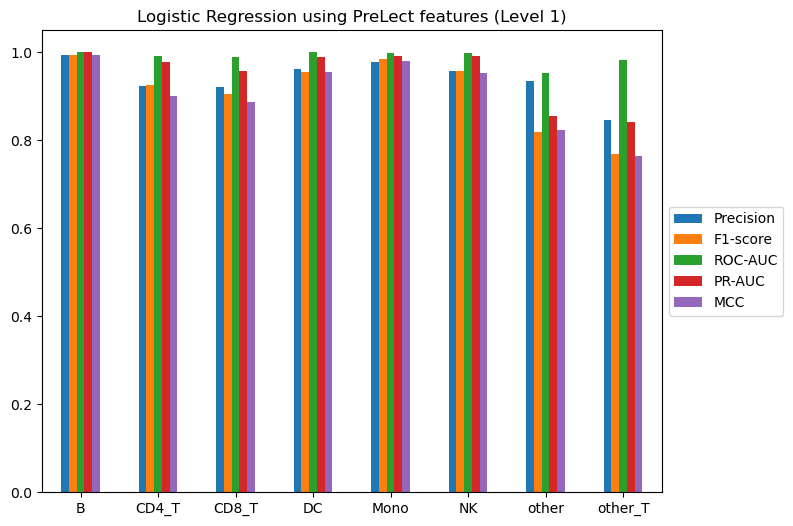

In [7]:
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
# Plot metrics for each celltype
ax = all_metrics[cols].plot.bar(rot=0, figsize=(8,6), title='Logistic Regression using PreLect features (Level 1)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Evaluate by DEGn

In [59]:
count_df

,Feature_count,Positive_feature_count
B,13,7
CD4_T,200,83
CD8_T,25,6
DC,25,15
Mono,21,11
NK,28,14
other,42,27
other_T,61,26


In [58]:
# Read DEG table
os.chdir("/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table")

celltype = 'B'
DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
n_features = count_df.loc[celltype, 'Feature_count']  # 3902
DEGn = DEG_table['names'][:n_features].tolist()

In [60]:
n_features

13

In [61]:
DEGn

['CD79A',
 'MS4A1',
 'RALGPS2',
 'BANK1',
 'CD79B',
 'CD74',
 'CD37',
 'HLA-DRA',
 'HLA-DQA1',
 'TNFRSF13C',
 'HLA-DPB1',
 'LINC00926',
 'IGHM']

In [68]:
def LR_classifier(data, DEGn, celltype):
    # subset data to DEGs
    X = data[:, DEGn].X
    print(X.shape)
    # Binary label
    y = [1 if i==celltype else 0 for i in data.obs['celltype.l1'].tolist()]

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)
    
    # train classifier
    clf = LogisticRegression(penalty='l2', solver='lbfgs', C=1.0, max_iter=1000)
    clf.fit(X_train, y_train)

    # evaluate classifier
    y_pred = clf.predict(X_test)
    y_score = clf.predict_proba(X_test)[:, 1]  # Probability estimates of the positive class

    # Calculate metrics
    accuracy = accuracy_score(y_test, y_pred)
    # print("Accuracy: {:.2f}%".format(accuracy * 100))
    precision = precision_score(y_test, y_pred)
    # print("Precision: {:.2f}%".format(precision * 100))
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    # print("F1: {:.2f}%".format(f1 * 100))
    roc_auc = roc_auc_score(y_test, y_score)
    # print('ROC-AUC:', roc_auc)
    average_precision = average_precision_score(y_test, y_score)  # PR-AUC
    mcc = matthews_corrcoef(y_test, y_pred)

    # model metrics
    metrics = [accuracy, precision, recall, f1, roc_auc, average_precision, mcc]

    return clf, metrics

In [63]:
!pwd

/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table


In [69]:
cols = ['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
all_metrics_DEG = pd.DataFrame(columns=cols)

for celltype in types:
    print('==================')
    print('Constructing classifier for:', celltype)
    n_features = count_df.loc[celltype, 'Feature_count']
    print('n:', n_features)
    DEG_table = pd.read_csv(celltype + '_DEG2000.csv', index_col=0)
    DEGn = DEG_table['names'][:n_features].tolist()

    clf, celltype_metrics = LR_classifier(data, DEGn, celltype)
    all_metrics_DEG.loc[celltype] = celltype_metrics

Constructing classifier for: B
n: 13
(161764, 13)
Constructing classifier for: CD4_T
n: 200
(161764, 200)


/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Constructing classifier for: CD8_T
n: 25
(161764, 25)
Constructing classifier for: DC
n: 25
(161764, 25)
Constructing classifier for: Mono
n: 21
(161764, 21)
Constructing classifier for: NK
n: 28
(161764, 28)
Constructing classifier for: other
n: 42
(161764, 42)
Constructing classifier for: other_T
n: 61
(161764, 61)


In [70]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998825,0.995269,0.990942,0.993101,0.999547,0.998740,0.992462
CD4_T,0.935276,0.872226,0.872439,0.872333,0.979447,0.941125,0.828982
CD8_T,0.969431,0.911735,0.892226,0.901875,0.986648,0.953562,0.883846
DC,0.996847,0.933803,0.923398,0.928571,0.998040,0.974410,0.926975
Mono,0.991593,0.977168,0.995511,0.986254,0.997475,0.989797,0.980288
NK,0.984947,0.931190,0.938923,0.935041,0.997317,0.980795,0.926538
other,0.991315,0.884688,0.680233,0.769104,0.931314,0.807368,0.771622
other_T,0.980064,0.824386,0.667158,0.737485,0.978793,0.819256,0.731644


In [74]:
os.chdir('/Users/evanli/Documents/EvanPys/Progress/PBMC_Hao_GSE/L1_by_lossdiff/L1_DEG/L1_DEG_table')
all_metrics_DEG.to_csv('L1_loss_diff_DEGn_metrics.csv')

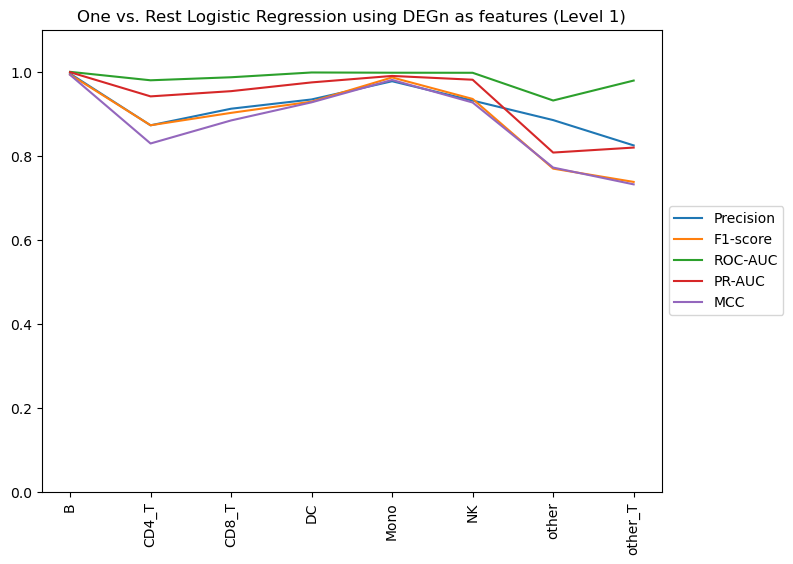

In [75]:
# line graph

# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = all_metrics_DEG[cols].plot.line(rot=0, figsize=(8, 6), title='One vs. Rest Logistic Regression using DEGn as features (Level 1)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

# Generate x-ticks for every data point
plt.xticks(np.arange(len(all_metrics.index)), all_metrics.index, rotation=90)
ax.set_ylim(0, 1.1)

plt.show()

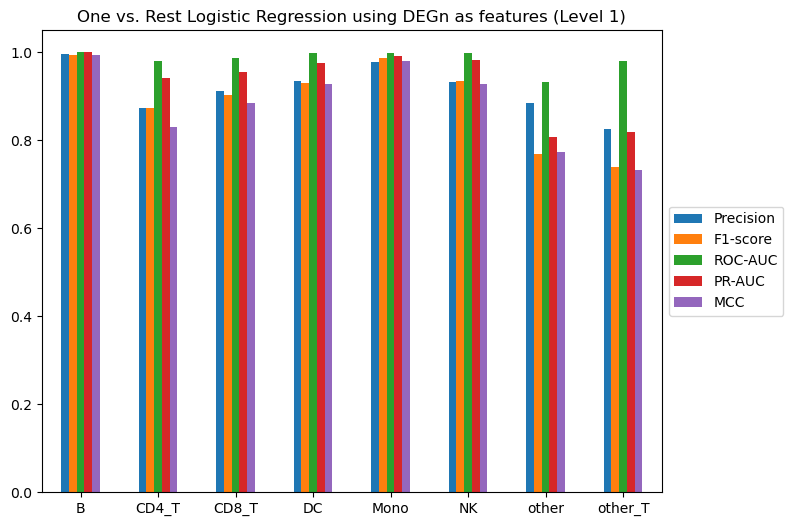

In [76]:
# Plot metrics for each celltype
ax = all_metrics_DEG[cols].plot.bar(rot=0, figsize=(8,6), title='One vs. Rest Logistic Regression using DEGn as features (Level 1)')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))

## Combine plots: ADlasso features vs. DEG

In [77]:
all_metrics

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998863,0.993767,0.992899,0.993329,0.999920,0.999358,0.992709
CD4_T,0.961339,0.924050,0.926344,0.924333,0.992166,0.977680,0.899153
CD8_T,0.970216,0.920194,0.887825,0.903650,0.988212,0.956941,0.886290
DC,0.998053,0.961301,0.950684,0.955895,0.999416,0.988437,0.954951
Mono,0.991049,0.976382,0.994532,0.985366,0.997828,0.992105,0.979013
NK,0.990097,0.956739,0.958102,0.957218,0.998551,0.990346,0.951748
other,0.993280,0.934213,0.737017,0.818854,0.953300,0.855213,0.824049
other_T,0.982153,0.846822,0.704073,0.768268,0.982465,0.840323,0.762894


In [78]:
all_metrics_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.998825,0.995269,0.990942,0.993101,0.999547,0.998740,0.992462
CD4_T,0.935276,0.872226,0.872439,0.872333,0.979447,0.941125,0.828982
CD8_T,0.969431,0.911735,0.892226,0.901875,0.986648,0.953562,0.883846
DC,0.996847,0.933803,0.923398,0.928571,0.998040,0.974410,0.926975
Mono,0.991593,0.977168,0.995511,0.986254,0.997475,0.989797,0.980288
NK,0.984947,0.931190,0.938923,0.935041,0.997317,0.980795,0.926538
other,0.991315,0.884688,0.680233,0.769104,0.931314,0.807368,0.771622
other_T,0.980064,0.824386,0.667158,0.737485,0.978793,0.819256,0.731644


In [79]:
AD_minus_DEG = all_metrics - all_metrics_DEG
AD_minus_DEG

,Accuracy,Precision,Recall,F1-score,ROC-AUC,PR-AUC,MCC
B,0.000037,-0.001503,0.001957,0.000228,0.000372,0.000619,0.000247
CD4_T,0.026062,0.051824,0.053905,0.052001,0.012719,0.036556,0.070171
CD8_T,0.000785,0.008459,-0.004401,0.001775,0.001564,0.003380,0.002444
DC,0.001205,0.027498,0.027286,0.027324,0.001376,0.014027,0.027976
Mono,-0.000544,-0.000786,-0.000979,-0.000889,0.000353,0.002308,-0.001274
NK,0.005149,0.025549,0.019178,0.022177,0.001234,0.009551,0.025210
other,0.001966,0.049525,0.056785,0.049750,0.021985,0.047844,0.052427
other_T,0.002089,0.022437,0.036916,0.030784,0.003672,0.021067,0.031250


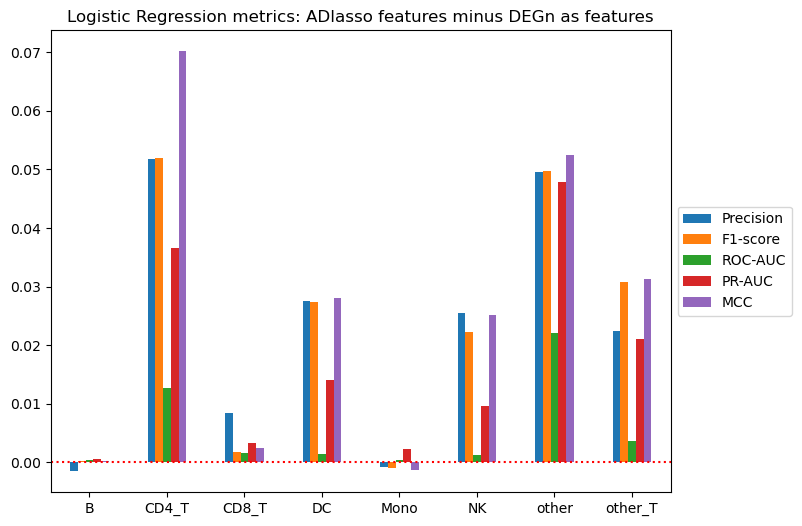

In [82]:
# Plot metrics for each celltype
cols = ['Precision', 'F1-score', 'ROC-AUC', 'PR-AUC', 'MCC']
ax = AD_minus_DEG[cols].plot.bar(rot=0, figsize=(8,6), title='Logistic Regression metrics: ADlasso features minus DEGn as features')
ax.legend(loc='center left', bbox_to_anchor=(1.0, 0.5))
# Add vertical red dotted line at y = 0
ax.axhline(y=0, color='red', linestyle='dotted')
